# SIR model for COVID-19 reproducing the paper from Ma, 2022

In [ ]:
import numpy as np
import matplotlib as plt
from scipy.integrate import odeint
import matplotlib.pyplot as plt

### Classic SIR model

\begin{align*} \frac{{dS\left(t \right)}}{{dt}} =& - \beta \frac{{S\left(t \right)I\left(t \right)}}{N} \tag{1}\\ \frac{{dI\left(t \right)}}{{dt}} =& \beta \frac{{S\left(t \right)I\left(t \right)}}{N} - \lambda I\left(t \right) \tag{2}\\ \frac{{dR\left(t \right)}}{{dt}} = & \lambda I\left(t \right) \tag{3} \end{align*}

### Extended SEIR model


\begin{align*} \frac{{dS\left(t \right)}}{{dt}} = & - \beta \frac{{S\left(t \right)I\left(t \right)}}{N} - \alpha S\left(t \right) \tag{4}\\ \frac{{dE\left(t \right)}}{{dt}} = & \beta \frac{{S\left(t \right)I\left(t \right)}}{N} - \gamma E\left(t \right) \tag{5}\\ \frac{{dI\left(t \right)}}{{dt}} = & \gamma E\left(t \right) - \delta I\left(t \right) \tag{6}\\ \frac{{dQ\left(t \right)}}{{dt}} = & \delta I\left(t \right) - \lambda Q\left(t \right) - \kappa Q\left(t \right) \tag{7}\\ \frac{{dR\left(t \right)}}{{dt}} = & \lambda Q\left(t \right) \tag{8}\\ \frac{{dD\left(t \right)}}{{dt}} = & \kappa Q\left(t \right) \tag{9}\\ \frac{{dP\left(t \right)}}{{dt}} = & \alpha S\left(t \right) \tag{10} \end{align*}



### States of the SEIR model

- N: total number of people
- S: susceptible people
- E: exposed people
- I: infected people not quarantined
- Q: infected people quarantined
- P: protected people
- R: recovered people
- D: dead people

### Parameters of the SEIR model
- $\alpha$: protection rate
- $\beta$: infectious rate
- $\gamma^1$: average incubation
- $\delta^1$: average quarantine time
- $\lambda$: cure rate
- $\kappa$: mortality rate


In [59]:
# Define function for the system of differential equations
def seir_model(y, t, N, beta, alpha, gamma, delta, kappa, lam):
    S, E, I, Q, R, D, P = y
    dSdt = -beta*S*I/N - alpha*S
    dEdt = beta*S*I/N - gamma*E
    dIdt = gamma*E - delta*I
    dQdt = delta*I - lam*Q - kappa*Q
    dRdt = lam*Q
    dDdt = kappa*Q
    dPdt = alpha*S
    return dSdt, dEdt, dIdt, dQdt, dRdt, dDdt, dPdt

# Set initial conditions with values from the paper
N = 14000000
E0 = 318
I0 = 389
Q0 = 700
R0 = 0
D0 = 0
P0 = 0
S0 = N - E0 - I0 - Q0 - R0 - D0 - P0

#Set initial parameters with values from the paper
beta = 0.7      # infectious rate
alpha = 0.0185  # protection rate
gamma = 1/5     # gamma^(-1)=average incubation
delta = 1/7     # delta^(-1)=average quarantine time
kappa = 0.001   # mortality rate
lam = 0.1       # cure rate

# Set time discretization as in the paper
t = np.linspace(0, 180, 10000)

# Solve system of differential equations
# Returns the seven variables S, E, I, Q, R, D, and P at each time point
sol = odeint(seir_model, [S0, E0, I0, Q0, R0, D0, P0], t, args=(N, beta, alpha, gamma, delta, kappa, lam))


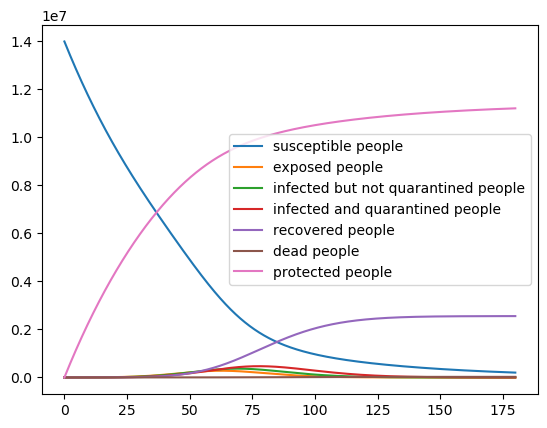

In [58]:
# Plot results

# dSdt, dEdt, dIdt, dQdt, dRdt, dDdt, dPdt
plt.plot(t,sol.T[0], label="susceptible people")
plt.plot(t,sol.T[1], label="exposed people")
plt.plot(t,sol.T[2], label="infected but not quarantined people")
plt.plot(t,sol.T[3], label="infected and quarantined people")
plt.plot(t,sol.T[4], label="recovered people")
plt.plot(t,sol.T[5], label="dead people")
plt.plot(t,sol.T[6], label="protected people")
plt.legend()

### Basic reproduction number

\begin{equation*} R0\ = \ \left({1 + \frac{{\ln (Y\left(t \right)/t)}}{\gamma }} \right)\left({1 + \frac{{\ln (Y\left(t \right)/t)}}{\lambda }} \right) \tag{11} \end{equation*}




In [53]:
# function to calculate R0 at a given time t
def calculate_R0(Y, t, gamma, lambd):
    return (1 + np.log(Y/t)/gamma) * (1 + np.log(Y/t)/lambd)
